![header](../figures/logos_partenaires._cmems_se.jpg)

# West Mediterranean: Benchmark DUACS geostrophic currents maps
 

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>West Mediterranean: Benchmark of DUACS geostrophic currents maps</center></h1>
 <h5> The notebook aims to evaluate the surface current maps produced by the DUACS system.</h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the current data from the drifters database distributed by CMEMS (INSITU_GLO_PHY_UV_DISCRETE_MY_013_044 product) </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated Sea surface currents maps with drifters database: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [10]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [4]:
time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-12-31'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')

# Gulf Stream region
region = 'WM'
lon_min = 1                                          # domain min longitude
lon_max = 20                                          # domain max longitude
lat_min = 30.                                          # domain min latitude
lat_max = 45.                                          # domain max latitude
box_lonlat_WM = {'lon_min':lon_min,'lon_max':lon_max,'lat_min':lat_min,'lat_max':lat_max}

method_name = 'DUACS'

stat_output_filename = f'{output_dir}/stat_uv_duacs_geos_WM.nc'   # output statistical analysis filename
psd_output_filename = f'{output_dir}/psd_uv_duacs_geos_WM.nc'     # output spectral analysis filename
segment_lenght = np.timedelta64(40, 'D')                      # spectral parameter: drifters segment lenght in days to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## [Sea Surface currents from Drifters database](https://doi.org/10.17882/86236)

In [5]:
filenames_drifters = sorted(glob('../data/independent_drifters/uv_*'))

In [6]:
%%time
ds_drifter = xr.open_mfdataset(filenames_drifters, combine='nested', concat_dim='time')
ds_drifter = ds_drifter.where((ds_drifter.time >= np.datetime64(time_min)) & (ds_drifter.time <=  np.datetime64(time_max)), drop=True)
ds_drifter

CPU times: user 4.48 s, sys: 769 ms, total: 5.25 s
Wall time: 6.22 s


<xarray.Dataset>
Dimensions:    (time: 2156405)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    latitude   (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(5559,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               116275
    date_update:                 2020-10-13T12:17:40Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              -58.44
    last_longitude_observation:  82.75
    last_latitude_observation:   -18.49
    date_drog_lost:              2017-01-21T03:37:00Z
    death_type:                  stop transmitting
    last_date_observation:       2019-01-16T01:51:00Z

## Sea Surface current maps to evaluate

In [7]:
%%time
list_of_maps = sorted(glob('../data/maps/DUACS_global_allsat-alg/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

CPU times: user 7.14 s, sys: 949 ms, total: 8.09 s
Wall time: 10.3 s


<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

## Selecting only West Mediterranean


In [8]:
from src.mod_compare import regional_zoom

ds_maps = regional_zoom(ds_maps, [box_lonlat_WM['lon_min'],box_lonlat_WM['lon_max']], [box_lonlat_WM['lat_min'],box_lonlat_WM['lat_max']], namelon='longitude', namelat='latitude', change_lon=True)
ds_maps

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 60, longitude: 76)
Coordinates:
  * latitude   (latitude) float32 30.12 30.38 30.62 30.88 ... 44.38 44.62 44.88
  * longitude  (longitude) float64 1.125 1.375 1.625 1.875 ... 19.38 19.62 19.88
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface currents maps onto drifters positions

In [11]:
%%time
ds_interp = run_interpolation_drifters(ds_maps, ds_drifter, time_min, time_max)
ds_interp = ds_interp.dropna('time')
ds_interp = ds_interp.sortby('time')
ds_interp

2023-10-05 13:50:18 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2023-10-05 13:50:19 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2023-10-05 13:50:20 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2023-10-05 13:50:22 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2023-10-05 13:50:23 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2023-10-05 13:50:24 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2023-10-05 13:50:26 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2023-10-05 13:50:27 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2023-10-05 13:50:28 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2023-10-05 13:50:30 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2023-10-05 13:50:31 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2023-10-05 13:50:32 INFO     fet

CPU times: user 36.9 s, sys: 7.4 s, total: 44.3 s
Wall time: 39.9 s


<xarray.Dataset>
Dimensions:            (time: 4434)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-01 ... 2019-12-31
Data variables:
    EWCT               (time) float32 -0.07437 0.2156 ... -0.3383 0.2524
    NSCT               (time) float32 -0.05773 -0.08433 ... -0.2411 -0.3417
    sensor_id          (time) float64 6.571e+07 6.631e+07 ... 6.755e+07
    latitude           (time) float32 35.27 43.14 35.26 ... 37.38 38.22 39.96
    longitude          (time) float32 18.99 9.469 19.01 ... 9.144 3.319 5.833
    ugos_interpolated  (time) float64 0.02016 0.04431 0.02043 ... -0.2049 0.2001
    vgos_interpolated  (time) float64 0.03675 0.1065 0.03187 ... 0.06885 -0.1139

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the surface currents maps have been interpolated to the position of the drifters, it is possible to calculate different statistics on the time series of zonal and meridional velocities. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps. 

In [12]:
# Compute gridded stats
compute_stat_scores_uv(ds_interp, stat_output_filename,method_name=method_name)

2023-10-05 13:51:04 INFO     Compute mapping error all scales
2023-10-05 13:51:04 INFO     Compute statistics
2023-10-05 13:51:06 INFO     Stat file saved as: ../results/stat_uv_duacs_geos_WM.nc
2023-10-05 13:51:06 INFO     Compute statistics by oceanic regime


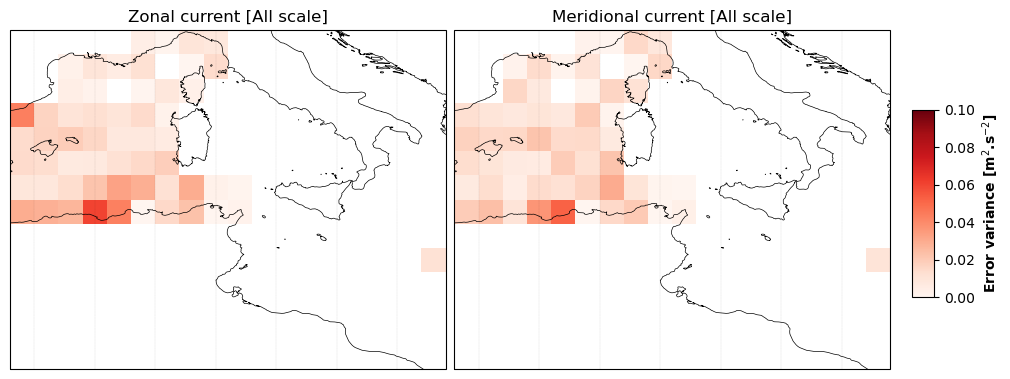

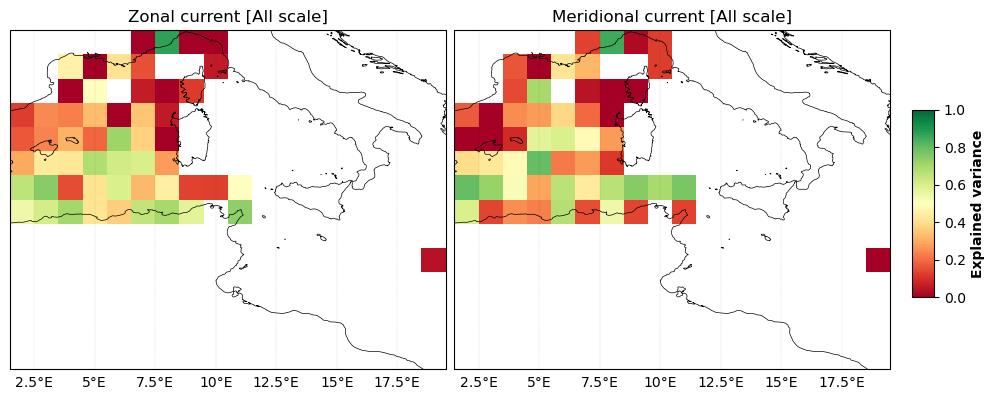

In [13]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map_uv(stat_output_filename)
# Matplotlib
plot_stat_score_map_uv_png(stat_output_filename,region=region,box_lonlat=box_lonlat_WM)

The figure shows that the maximum mapping errors are found in intense current systems, for example in the GulfStream, Kuroshio and Agulhas regions. 

However, when considering the full scale of motion in the drifter database, the surface current maps capture up to 80% of the variability of drifter currents in the Western Boundary Currents and Antarctic Circumpolar Currents (ACC). The geostrophic signal dominates the ageostrophic signal in these regions. In regions with low ocean variability, only a few percent of the total drifter current variability is recovered in the maps, which may be associated with a larger ageostrophic signal in these regions.

In [14]:
plot_stat_uv_by_regimes(stat_output_filename)

,mapping_err_u_var [m²/s²],mapping_err_v_var [m²/s²],ugos_interpolated_var [m²/s²],EWCT_var [m²/s²],vgos_interpolated_var [m²/s²],NSCT_var [m²/s²],var_score_u_allscale,var_score_v_allscale
coastal,0.017437,0.014889,0.014146,0.038460,0.010903,0.028870,0.546625,0.484267
offshore_highvar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offshore_lowvar,0.013315,0.013192,0.001338,0.014034,0.001467,0.012317,0.051228,-0.071033
equatorial_band,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antarctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.4 Compute Spectral scores

In [15]:
# Compute PSD scores
compute_psd_scores_current(ds_interp, psd_output_filename, lenght_scale=segment_lenght, method_name=method_name)

2023-10-05 13:51:49 INFO     Segment computation...
2023-10-05 13:51:49 INFO     Spectral analysis...
2023-10-05 13:51:49 INFO     Write output...
2023-10-05 13:51:49 INFO     PSD file saved as: ../results/psd_uv_duacs_geos_WM.nc


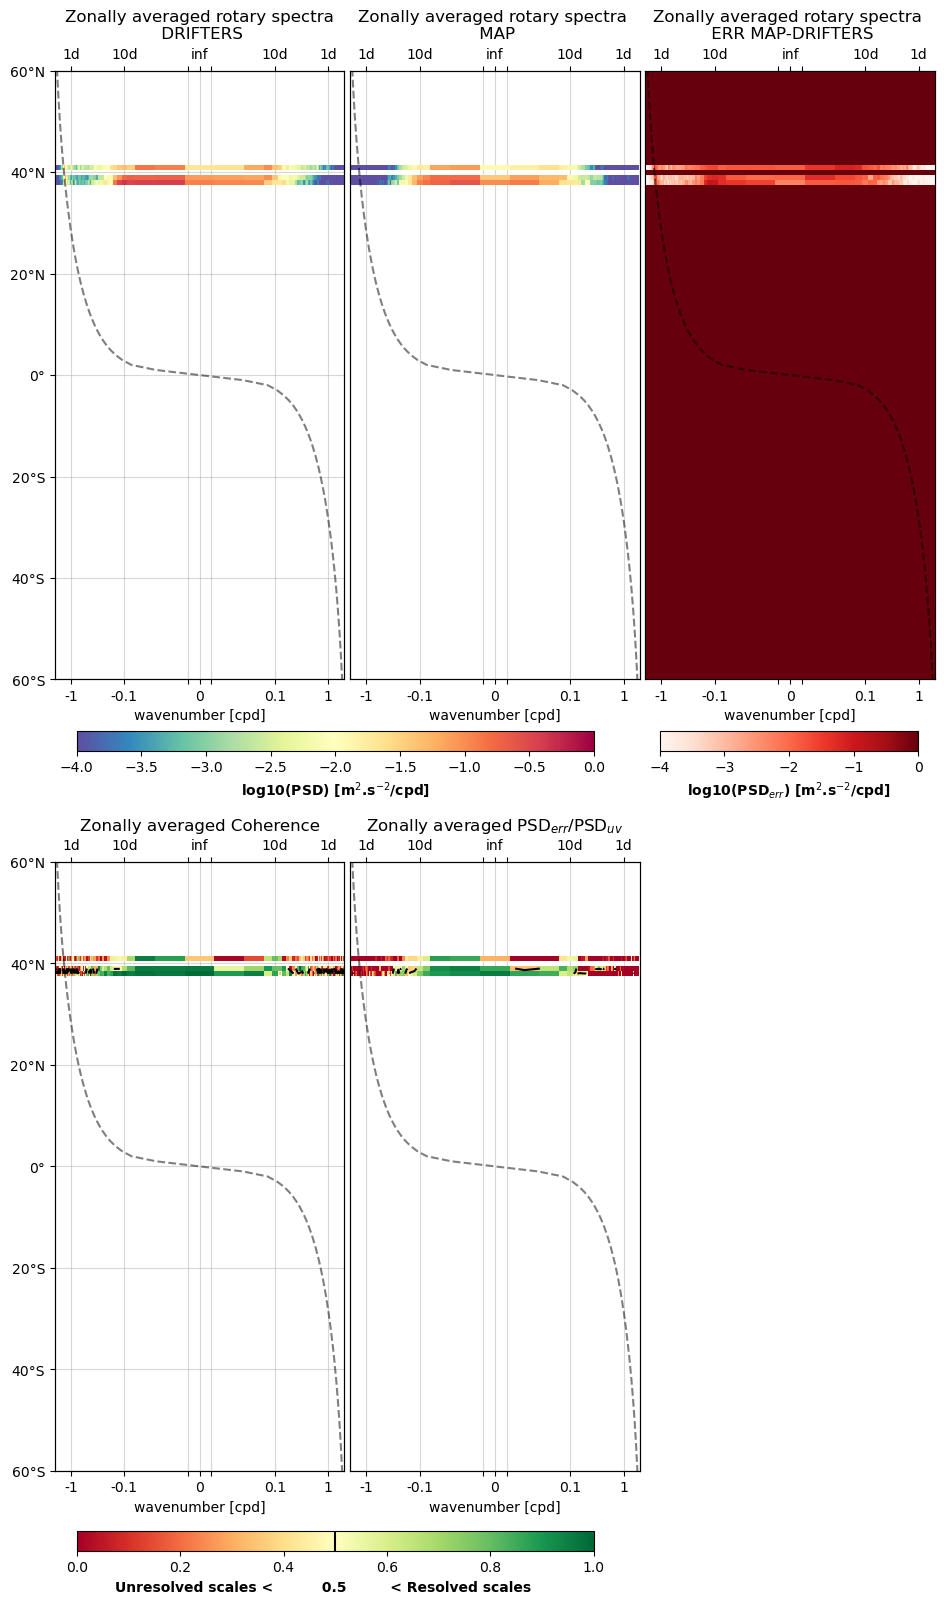

In [16]:
# Plot Zonally averaged rotary spectra
# Hvplot
# plot_psd_scores_currents(psd_output_filename)
# Matplotlib
plot_psd_scores_currents_png(psd_output_filename,region=region)

In [17]:
# Plot Zonally averaged rotary spectra
plot_psd_scores_currents_1D(psd_output_filename)

:Layout
   .DynamicMap.I  :DynamicMap   [lat]
      :Overlay
         .Curve.PSD_drifters :Curve   [wavenumber]   (psd_ref)
         .Curve.PSD_maps     :Curve   [wavenumber]   (psd_study)
   .DynamicMap.II :DynamicMap   [lat]
      :Overlay
         .Curve.Coherence           :Curve   [wavenumber]   (coherence)
         .Curve.PSD_err_over_PSDref :Curve   [wavenumber]   (psd_err_psd_ref)

The interactive plot above allows you to explore the spectral metrics by latitude band